In [ ]:
# default_exp rl.policies.thompson_sampling

# Thompson Sampling
> Implementation of Thompson Sampling Policies.

In [ ]:
#export
import numpy as np
import scipy
import scipy.stats as stats

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the multi-armed bandits
nb_bandits = 3  # Number of bandits

# True probability of winning for each bandit
p_bandits = [0.45, 0.55, 0.60]

plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]

We defined 3 bandits and the probability of winning is 45%, 55%, and 60%. We randomly pull an arm by generating a random number and if that number is less than the bandit probability, we call it a success for that arm and return 1 (positive reward), else return 0 (no reward).

In [ ]:
def pull(i):
    """Pull arm of bandit with index `i` and return 1 if win, 
    else return 0."""
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

In [ ]:
def plot(priors, step, ax):
    """Plot the priors for the current step."""
    plot_x = np.linspace(0.001, .999, 100)
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        ax.fill_between(plot_x, y, 0, alpha=0.2)
    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0)
    ax.set_title(f'Priors at step {step:d}')

Simulate multi-armed bandit process and update posteriors. The number of trials and wins will represent the prior for each bandit with the help of the Beta distribution.

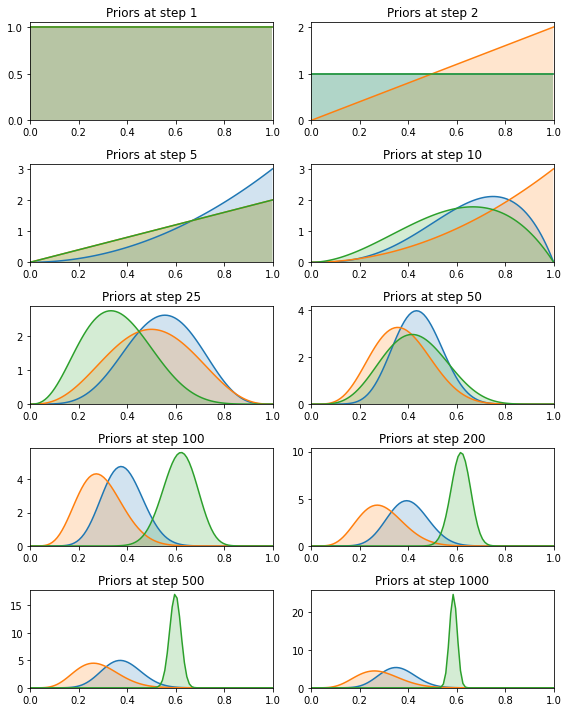

In [ ]:
# Setup plot
fig, axs = plt.subplots(5, 2, figsize=(8, 10))
axs = axs.flat

# The number of trials and wins will represent the prior for each
#  bandit with the help of the Beta distribution.
trials = [0, 0, 0]  # Number of times we tried each bandit
wins = [0, 0, 0]  # Number of wins for each bandit

n = 1000
# Run the trail for `n` steps
for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # plot prior 
    if step in plots:
        plot(bandit_priors, step, next(axs))
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x

plt.tight_layout()
plt.show()

As we can see, the probability density plot was uniform at the beginning and started converging to the mean of actual probability as the steps increase.



> Note: Note: the good thing about beta distribution is that it can take form of both, uniform distribution (at step 1) as well as normal distribution (at step 1000) depending upon the alpha and beta parameters.

In [ ]:
# Print final outcome and number of test needed per bandit
emperical_p_bandits = [(1+w) / (1+t) for t, w in zip(trials, wins)]
for i in range(nb_bandits):
    print((f'True prob={p_bandits[i]:.2f};  '
           f'Emperical prob={emperical_p_bandits[i]:.2f};  '
           f'Trials={trials[i]:d}'))

True prob=0.45;  Emperical prob=0.37;  Trials=40
True prob=0.55;  Emperical prob=0.29;  Trials=23
True prob=0.60;  Emperical prob=0.59;  Trials=937


For bandit 1, true probability of success is 45% and agent estimated 37% in 40 trials. Similar case for bandit 2. In case of bandit 3, trials are comparatively large because that one is the highest probability of success class and therefore the agent keeps pulling this bandit to maximize the reward.

We can also see the agent's performance on each step/pull.

In [ ]:
p_bandits = [0.45, 0.55, 0.60]
trials = [0, 0, 0]
wins = [0, 0, 0]
n = 10

for step in range(1, n+1):
    # Define the prior based on current observations
    bandit_priors = [
        stats.beta(a=1+w, b=1+t-w) for t, w in zip(trials, wins)]
    # Sample a probability theta for each bandit
    theta_samples = [
        d.rvs(1) for d in bandit_priors
    ]
    # choose a bandit
    chosen_bandit = np.argmax(theta_samples)
    # Pull the bandit
    x = pull(chosen_bandit)
    # Update trials and wins (defines the posterior)
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x
    print(p_bandits,trials,wins)

[0.45, 0.55, 0.6] [1, 0, 0] [0, 0, 0]
[0.45, 0.55, 0.6] [1, 1, 0] [0, 0, 0]
[0.45, 0.55, 0.6] [1, 2, 0] [0, 1, 0]
[0.45, 0.55, 0.6] [1, 3, 0] [0, 2, 0]
[0.45, 0.55, 0.6] [1, 4, 0] [0, 2, 0]
[0.45, 0.55, 0.6] [1, 5, 0] [0, 3, 0]
[0.45, 0.55, 0.6] [1, 5, 1] [0, 3, 1]
[0.45, 0.55, 0.6] [1, 6, 1] [0, 3, 1]
[0.45, 0.55, 0.6] [1, 6, 2] [0, 3, 2]
[0.45, 0.55, 0.6] [1, 6, 3] [0, 3, 2]


In each row, first list is the probability of success for each bandit, 2nd list is the total count of pull and 3rd list is the total count of win. At step 1, agent pulled third arm and get a reward of 1. At step 2, agent pulled first arm, and get no reward. Then again pulled third arm and get a reward. In first 10 steps, agent pulled 3rd arm 6 times and got a total reward 5 times out of 6.

But the good thing about the Thompson sampling algorithm is that even this high reward from the 3rd arm situation will not stop the agent from exploring from time to time. So if we change the actual probabilities from [0.45, 0.55, 0.6] to let's say [0.9, 0.55, 0.6], the agent will itself identify this change in reward and will start pulling the first arm instead.

We wrapped the thompson sampling algorithm in a class where we defined 2 methods: pull - to draw an arm at random, and step - that will internally pull the arms at random and keep updating the bandit posteriors.

In [ ]:
#export
class ThompsonSampling():
    def __init__(self, nb_bandits):
        self.nb_bandits = nb_bandits
        self.trials = [0] * self.nb_bandits
        self.wins = [0] * self.nb_bandits

    def pull(self, i, p_bandits):
        if np.random.rand() < p_bandits[i]:
            return 1
        else:
            return 0

    def step(self, p_bandits):
        # Define the prior based on current observations
        bandit_priors = [stats.beta(a=1+w, b=1+t-w) for t, w in zip(self.trials, self.wins)]
        # Sample a probability theta for each bandit
        theta_samples = [d.rvs(1) for d in bandit_priors]
        # choose a bandit
        chosen_bandit = np.argmax(theta_samples)
        # Pull the bandit
        x = self.pull(chosen_bandit, p_bandits)
        # Update trials and wins (defines the posterior)
        self.trials[chosen_bandit] += 1
        self.wins[chosen_bandit] += x
        return self.trials, self.wins

In [ ]:
n_bandits = 10
thsim = ThompsonSampling(nb_bandits=n_bandits)
p_bandits = [np.random.rand() for i in range(n_bandits)]
thsim.step(p_bandits)

([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])